In [1]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from clip_pipeline_attend_and_excite import RelationalAttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter, run_on_prompt_and_image, run_on_prompt_and_masked_image
from utils import vis_utils
from utils.ptp_utils import AttentionStore, show_cross_attention_binary

from utils.vis_utils import vis_ann

from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload 
%autoreload 2

# Load Model

In [2]:
NUM_DIFFUSION_STEPS = 200
GUIDANCE_SCALE = 12.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = RelationalAttendAndExcitePipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None).to(device)
tokenizer = stable.tokenizer

/home/hansun/.conda/envs/diffusers/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'clip_pipeline_attend_and_excite.RelationalAttendAndExcitePipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


# Prompt and guidance image

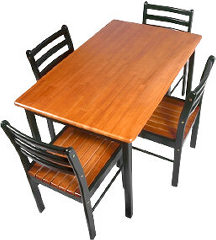

In [3]:
from PIL import Image

type = "table"
tokens = "8"
prompt = f"a photo of a {type} that is faded"
normal_prompt = f"a photo of a {type}"
detailed_prompt = f"a photo of a {type} with areas of discoloration or lightening due to prolonged sun exposure"

root_path = f"./example_web/"
image_guidance_path = root_path + "table.jpg"


image_guidance = Image.open(image_guidance_path).convert("RGB")
original_size = image_guidance.size
image_guidance.thumbnail((768, 768))
image_guidance.show()

# Pipeline Wrapper

In [4]:
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    init_image: Image.Image,
                    init_image_guidance_scale: float,
                    mask_image: str,
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    normal_prompt=normal_prompt,
                    detailed_prompt=detailed_prompt):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       n_inference_steps=NUM_DIFFUSION_STEPS,
                       guidance_scale=GUIDANCE_SCALE)
    image, image_latent = run_on_prompt_and_masked_image(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          init_image=init_image,
                          init_image_guidance_scale=init_image_guidance_scale,
                          mask_image=mask_image,
                          seed=generator,
                          config=config,
                          normal_prompt=normal_prompt,
                          detailed_prompt=detailed_prompt)
    if display_output:
        display(image)
    return image, image_latent

# Anomaly Generation

{1: 'a',
 2: 'photo',
 3: 'of',
 4: 'a',
 5: 'table',
 6: 'that',
 7: 'is',
 8: 'faded'}
Altering tokens: ['faded']


/home/hansun/nas/hansun/CODE/CODE_RELEASE/AnomalyAny/clip_pipeline_attend_and_excite.py:706: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/200 [00:00<?, ?it/s]

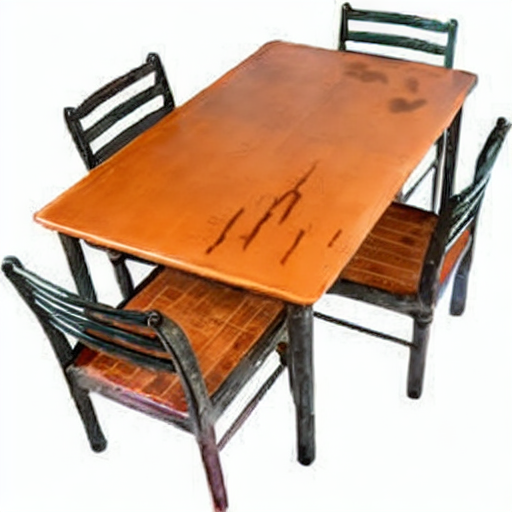

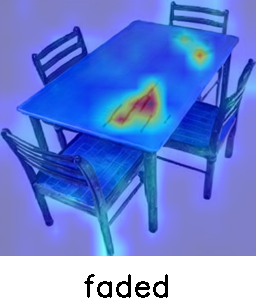

  0%|          | 0/200 [00:00<?, ?it/s]

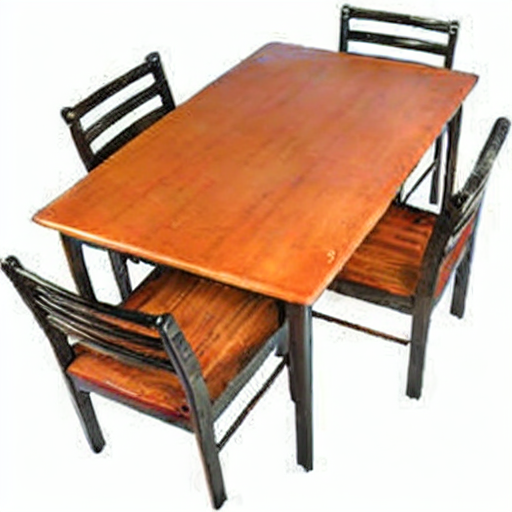

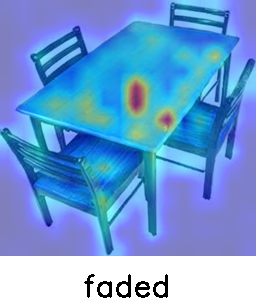

  0%|          | 0/200 [00:00<?, ?it/s]

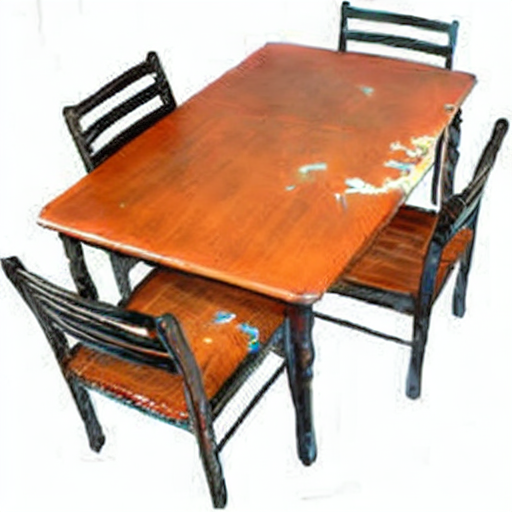

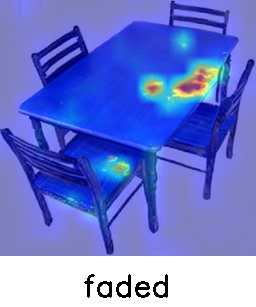

  0%|          | 0/200 [00:00<?, ?it/s]

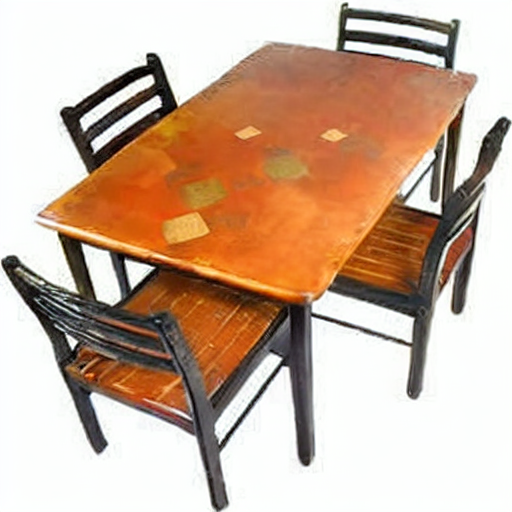

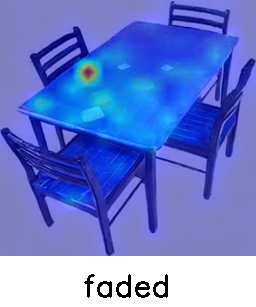

In [5]:
import random
from run import get_indices_to_alter_new
import time

seeds = [random.randint(0, 100000), random.randint(0, 100000), random.randint(0, 100000), random.randint(0, 100000)]

token_indices = get_indices_to_alter_new(stable, prompt, tokens)


compute_time = []
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()

    start_time = time.time()
    image, image_latent = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            # init_image=None,
                            init_image=image_guidance,
                            init_image_guidance_scale=0.3,
                            mask_image=None,   
                            generator=g,
                            run_standard_sd=False,
                            display_output=True,
                            scale_factor=50,
                            normal_prompt=normal_prompt,
                            detailed_prompt=detailed_prompt,)
    # print("--- %s seconds ---" % (time.time() - start_time))
    compute_time.append((time.time() - start_time))
    
    attention_images=vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

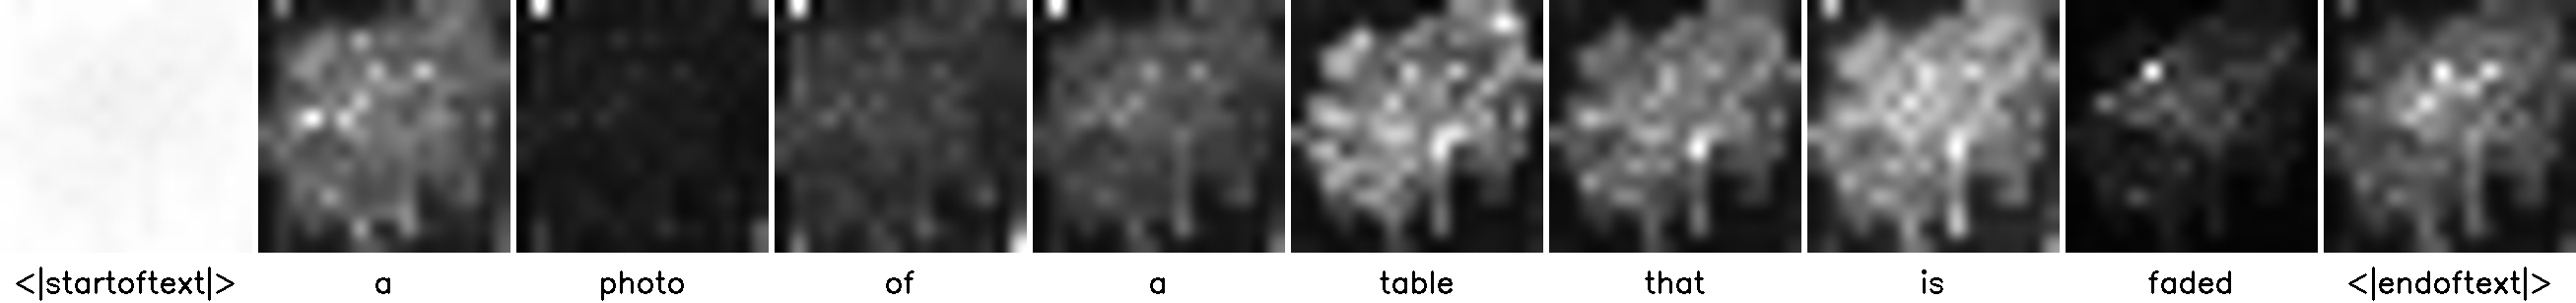

: 

In [ ]:
images, attention_maps = show_cross_attention_binary(controller, tokenizer, prompts, res=16, from_where=("up", "mid", "down"))

In [6]:
print(torch.cuda.memory_summary())

# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   40817 MB |   72844 MB |   96886 GB |   96846 GB |
|       from large pool |   40580 MB |   72229 MB |   95734 GB |   95694 GB |
|       from small pool |     236 MB |     618 MB |    1152 GB |    1151 GB |
|---------------------------------------------------------------------------|
| Active memory         |   40817 MB |   72844 MB |   96886 GB |   96846 GB |
|       from large pool |   40580 MB |   72229 MB |   95734 GB |